### Authors
Cathal Crowe - 21320128 \
Robert Flanagan - 21311625 \
Steven Lavelle - 21316945

### Execution
The code executes to the end without an error.

### References
https://keras.io/examples/rl/deep_q_network_breakout \
https://ale.farama.org/environments/breakout \
https://gymnasium.farama.org \
https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py

In [26]:
# Import our dependencies
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.wrappers import (
    AtariPreprocessing,
    FrameStackObservation,
    RecordVideo,
)
import ale_py
import matplotlib.pyplot as plt

In [27]:
# Configure our parameters
seed = 42
gamma = 0.99
learning_rate = 0.0001
max_episodes = 3000
epsilon_max = 1
epsilon_min = 0.01
epsilon_decay = np.exp(np.log(epsilon_min / epsilon_max) / max_episodes)
weight_decay = 0.0001
batch_size = 64
max_steps_per_episode = 1000
replay_buffer_size = 100000
target_update_frequency = 1000
start_training_after = 1000
update_after_actions = 4
video_folder = "recorded_episodes"

In [ ]:
# Track highest reward and episode
highest_reward = 0
highest_reward_episode = 0

# Environment setup
os.makedirs(video_folder, exist_ok=True)

gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda x: x % 100 == 0,
)
env = AtariPreprocessing(env, frame_skip=1)
env = FrameStackObservation(env, 4)

env.reset(seed=seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Define our model
num_actions = 4
input_dim = (4, 84, 84)
output_dim = num_actions

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim

        # Convolutional layers
        self.feature_layer = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Compute the output size of the convolutional layers
        conv_output_size = self.conv_output_dim()
        hidden_size = 512

        # Separate streams for value and advantage
        self.value_stream = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),  # Outputs scalar state-value V(s)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_dim),  # Outputs advantages A(s, a)
        )

    # Compute the output size of the convolutional layers
    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.feature_layer(x)
        return int(np.prod(x.shape))

    # Forward pass
    def forward(self, x):
        x = self.feature_layer(x)
        x = x.view(x.shape[0], -1)

        # Compute value and advantages
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine streams to calculate Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

model = DuelingDQN(input_dim, output_dim).to(device)
model_target = DuelingDQN(input_dim, output_dim).to(device)
model_target.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

In [30]:
# Experience replay buffers
action_history, state_history, state_next_history = [], [], []
rewards_history, done_history = [], []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

In [31]:
# Plot training performance
def plot_training_performance(episode_rewards, running_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(running_rewards, label='Running Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Performance')
    plt.legend()
    plt.show()

Episode 1 - Reward: 3.000, Running Reward: 0.000, Epsilon: 0.998, Highest Reward: 3.000 (Episode 1)
Episode 2 - Reward: 5.000, Running Reward: 3.000, Epsilon: 0.997, Highest Reward: 5.000 (Episode 2)
Episode 3 - Reward: 1.000, Running Reward: 4.000, Epsilon: 0.995, Highest Reward: 5.000 (Episode 2)
Episode 4 - Reward: 1.000, Running Reward: 3.000, Epsilon: 0.994, Highest Reward: 5.000 (Episode 2)
Episode 5 - Reward: 3.000, Running Reward: 2.500, Epsilon: 0.992, Highest Reward: 5.000 (Episode 2)
Episode 6 - Reward: 0.000, Running Reward: 2.600, Epsilon: 0.991, Highest Reward: 5.000 (Episode 2)
Episode 7 - Reward: 1.000, Running Reward: 2.167, Epsilon: 0.989, Highest Reward: 5.000 (Episode 2)
Episode 8 - Reward: 1.000, Running Reward: 2.000, Epsilon: 0.988, Highest Reward: 5.000 (Episode 2)
Episode 9 - Reward: 0.000, Running Reward: 1.875, Epsilon: 0.986, Highest Reward: 5.000 (Episode 2)
Episode 10 - Reward: 0.000, Running Reward: 1.667, Epsilon: 0.985, Highest Reward: 5.000 (Episode 2)

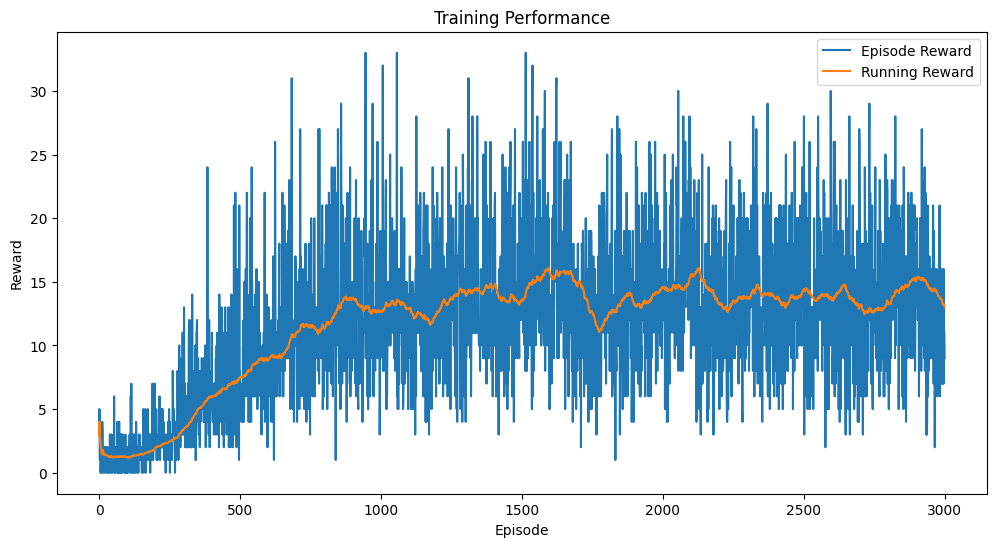

In [32]:
# Collect episode rewards and running rewards
episode_rewards = []
running_rewards = []

# Set epsilon to 1 for exploration
epsilon = epsilon_max

# Train the model
try:
    while True:
        observation, _ = env.reset()
        state = np.array(observation)
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            frame_count += 1

            # Epsilon-greedy exploration
            if frame_count < start_training_after or np.random.rand(1)[0] < epsilon:
                action = np.random.choice(num_actions)
            else:
                with torch.no_grad():
                    state_tensor = (
                        torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    )
                    action_probs = model(state_tensor)
                    action = action_probs.argmax().cpu().item()

            # Environment step
            state_next, reward, done, _, _ = env.step(action)
            state_next = np.array(state_next)

            episode_reward += reward

            # Save experiences
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            # Update network
            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
                # Sample batch
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                # Prepare batch tensors
                state_sample = torch.tensor(
                    np.array([state_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                state_next_sample = torch.tensor(
                    np.array([state_next_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                rewards_sample = torch.tensor(
                    [rewards_history[i] for i in indices], dtype=torch.float32
                ).to(device)
                action_sample = torch.tensor(
                    [action_history[i] for i in indices], dtype=torch.long
                ).to(device)
                done_sample = torch.tensor(
                    [float(done_history[i]) for i in indices], dtype=torch.float32
                ).to(device)

                # Double DQN logic - select action using the main network
                with torch.no_grad():
                    # Get actions from the main network
                    action_next = model(state_next_sample).argmax(1)
                    # Evaluate actions using the target network
                    target_q_values = (
                        model_target(state_next_sample)
                        .gather(1, action_next.unsqueeze(1))
                        .squeeze(1)
                    )
                    updated_q_values = rewards_sample + gamma * target_q_values * (
                        1 - done_sample
                    )

                # Compute Q-values
                q_values = model(state_sample)
                q_action = q_values.gather(1, action_sample.unsqueeze(1)).squeeze(1)

                # Compute loss
                loss = F.smooth_l1_loss(q_action, updated_q_values)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if frame_count % target_update_frequency == 0:
                model_target.load_state_dict(model.state_dict())

            # Trim memory
            if len(rewards_history) > replay_buffer_size:
                for history in [
                    rewards_history,
                    state_history,
                    state_next_history,
                    action_history,
                    done_history,
                ]:
                    del history[:1]

            if done:
                break
        # Decay exploration (epsilon) after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        episode_count += 1

        # Update highest reward and episode
        if episode_reward > highest_reward:
            highest_reward = episode_reward
            highest_reward_episode = episode_count
            
        print(
            f"Episode {episode_count} - Reward: {episode_reward:.3f}, "
            f"Running Reward: {running_reward:.3f}, Epsilon: {epsilon:.3f}, "
            f"Highest Reward: {highest_reward:.3f} (Episode {highest_reward_episode})"
        )

        # Collect rewards for plotting
        episode_rewards.append(episode_reward)
        running_reward = np.mean(episode_rewards[-100:])
        running_rewards.append(running_reward)

        # Termination conditions
        if episode_count >= max_episodes:
            print(f"Stopped at episode {episode_count}!")
            break
finally:
    env.close()

# Plot the training performance
plot_training_performance(episode_rewards, running_rewards)